# Gaussian Mixture Model

In [1]:
import sys
import torch
import numpy as np
import scipy.stats
from torch.nn import Softmax
from torch.autograd import Variable
from matplotlib import pyplot
%matplotlib inline

import pyro
from pyro.optim import Adam
from pyro.infer.svi import SVI
from pyro.distributions import bernoulli, categorical, delta, normal, dirichlet, gamma, normal
from pyro.util import ng_zeros, ng_ones
softmax = Softmax(dim=-1)

## Dataset

Here is our tiny dataset. It has five points.

In [2]:
data = Variable(torch.Tensor([0, 1, 10, 11, 12]))

## Maximum likelihood approach

Let's start by optimizing model parameters `ps`, `mu`, and `sigma`, rather than treating them as random variables with priors.

In [53]:
K = 2  # Fixed number of components.

def model(data):
    # Global parameters.
    ps = softmax(pyro.param('pre_ps', Variable(torch.zeros(K),
                                               requires_grad=True)))
    ps = ps.view(1, -1).expand(len(data), -1)
    mu = pyro.param('mu', Variable(torch.normal(torch.zeros(K), torch.ones(K)),
                                   requires_grad=True))
    sigma = pyro.param('sigma', Variable(torch.ones(1), requires_grad=True))

    # Local parameters.
    with pyro.iarange('data'):
        z = pyro.sample('z', categorical, ps).squeeze(-1)
        #assert z.shape == (K,), z.shape
        mu_z = mu.index_select(0, z).unsqueeze(-1)
        assert mu_z.shape == (5, 1), mu_z.shape
        pyro.observe('x', normal, data.unsqueeze(-1), mu_z, sigma.expand_as(mu_z))

def guide(data):
    with pyro.iarange('data'):
        p = softmax(pyro.param('pre_p', Variable(torch.zeros(len(data), K), requires_grad=True)))
        pyro.sample('z', categorical, p)

We'd like to implement EM by summing rather than sampling on the line marked "SAMPLE".

In [54]:
optim = pyro.optim.Adam({'lr': 0.1})
inference = SVI(model, guide, optim, 'ELBO', enum_discrete=True)

In [63]:
%pdb off
pyro.set_rng_seed(0)
pyro.get_param_store().clear()  # See https://github.com/uber/pyro/issues/175
iters = []
loss = []
for i in range(50):
    inference.step(data)
    if i % 1 == 0:
        iters.append(i)
        loss.append(inference.step(data))
        sys.stdout.write('.' if i % 80 else '\n')
        sys.stdout.flush()

Automatic pdb calling has been turned OFF

.................................................

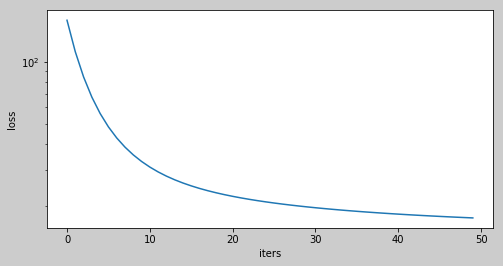

In [64]:
pyplot.figure(figsize=(8,4)).set_facecolor('#cccccc')
pyplot.plot(iters, loss)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')

In [60]:
ps = softmax(pyro.param('pre_ps'))
mu = pyro.param('mu')
sigma = pyro.param('sigma')

Text(0,0.5,u'probability density')

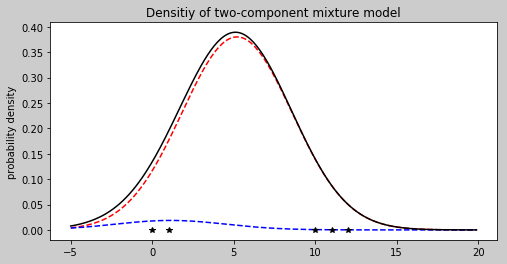

In [61]:
X = np.arange(-5,20,0.1)
Y1 = ps.data[0] * scipy.stats.norm.pdf((X - mu.data[0]) / sigma.data[0])
Y2 = ps.data[1] * scipy.stats.norm.pdf((X - mu.data[1]) / sigma.data[0])

pyplot.figure(figsize=(8, 4)).set_facecolor('#cccccc')
pyplot.plot(X, Y1, 'r--')
pyplot.plot(X, Y2, 'b--')
pyplot.plot(X, Y1 + Y2, 'k-')
pyplot.plot(data.data.numpy(), np.zeros(len(data)), 'k*')
pyplot.title('Densitiy of two-component mixture model')
pyplot.ylabel('probability density')

## Fully Bayesian aproach

Next we'll treat `ps`, `mu`, and `sigma` as random variables.

TODO